In [607]:
import numpy as np
import pandas as pd

In [615]:
datos.columns

Index(['country_code', 'year', 'reporting_level', 'welfare_type', 'percentile',
       'avg_welfare', 'pop_share', 'welfare_share', 'quantile', 'pop'],
      dtype='object')

In [622]:
datos = pd.read_csv('../datos reales/percentiles_ingresos_PPA_2011.csv')
datos = datos[datos['reporting_level'] == 'national']
datos_in = datos[datos['welfare_type']=='income']
datos_co = datos[datos['welfare_type']=='consumption']


In [758]:
from scipy.stats import shapiro
years = list(sorted(datos_in['year'].unique()))
def GenSeries(data):
    dy = data.groupby('year')
    series = []
    for year in years:
        if year not in dy.groups: 
            series.append([])
            continue
        dyi = dy.get_group(year)
        dyi = dyi.groupby('country_code')
        serie = []
        for cd in dyi.groups:
            grupo = dyi.get_group(cd)
            if len(grupo)<100 : continue
            serie.append(shapiro(np.log(grupo['avg_welfare'])).pvalue)
        series.append(serie)
    return series

In [776]:
def Graficar(ax, series, tipo):
    x = np.concatenate(list([years[i]]*len(series[i]) for i in range(len(years))), axis=0)
    y = np.concatenate(series, axis=0)
        
    ax.scatter(
        x + np.random.uniform(-0.25,0.25, size = len(x)), y,
        label="Observaciones: p-valor Shapiro"
    )

    ax.plot(
        years,
        [sum([si<0.05 for si in serie])/len(serie) if len(serie) else 0 for serie in series],
        marker='x', c = 'orange', label = "Prop. Observaciones p-valor<0.05",
        linewidth=5
    )
    ax.set_xticks(years, years, rotation=90, fontsize=14)
    ax.set_yticks(np.linspace(0,1,11),[f"{xi :0.2f}" for xi in np.linspace(0,1,11)], fontsize=14, minor = False)
    ax.set_yticks(np.linspace(0,1,21),  minor = True)

    ax.set_title("Log-Normalidad de la distribución del {tipo}", fontsize=42)
    #plt.ylabel("p-valor Test de Shapiro (log)", fontsize=20)
    ax.set_xlabel("Año",fontsize=20)
    ax.grid(linewidth=2, which='major', zorder=-4)
    ax.grid(linewidth=1.5, linestyle='--',which='minor', zorder=-5)
    ax.set_xlim(1962,2024)
    # plt.yscale('log')
    plt.legend(fontsize=18, loc = (0,0.2))

/tmp/ipykernel_341335/245428189.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=18, loc = (0,0.2))


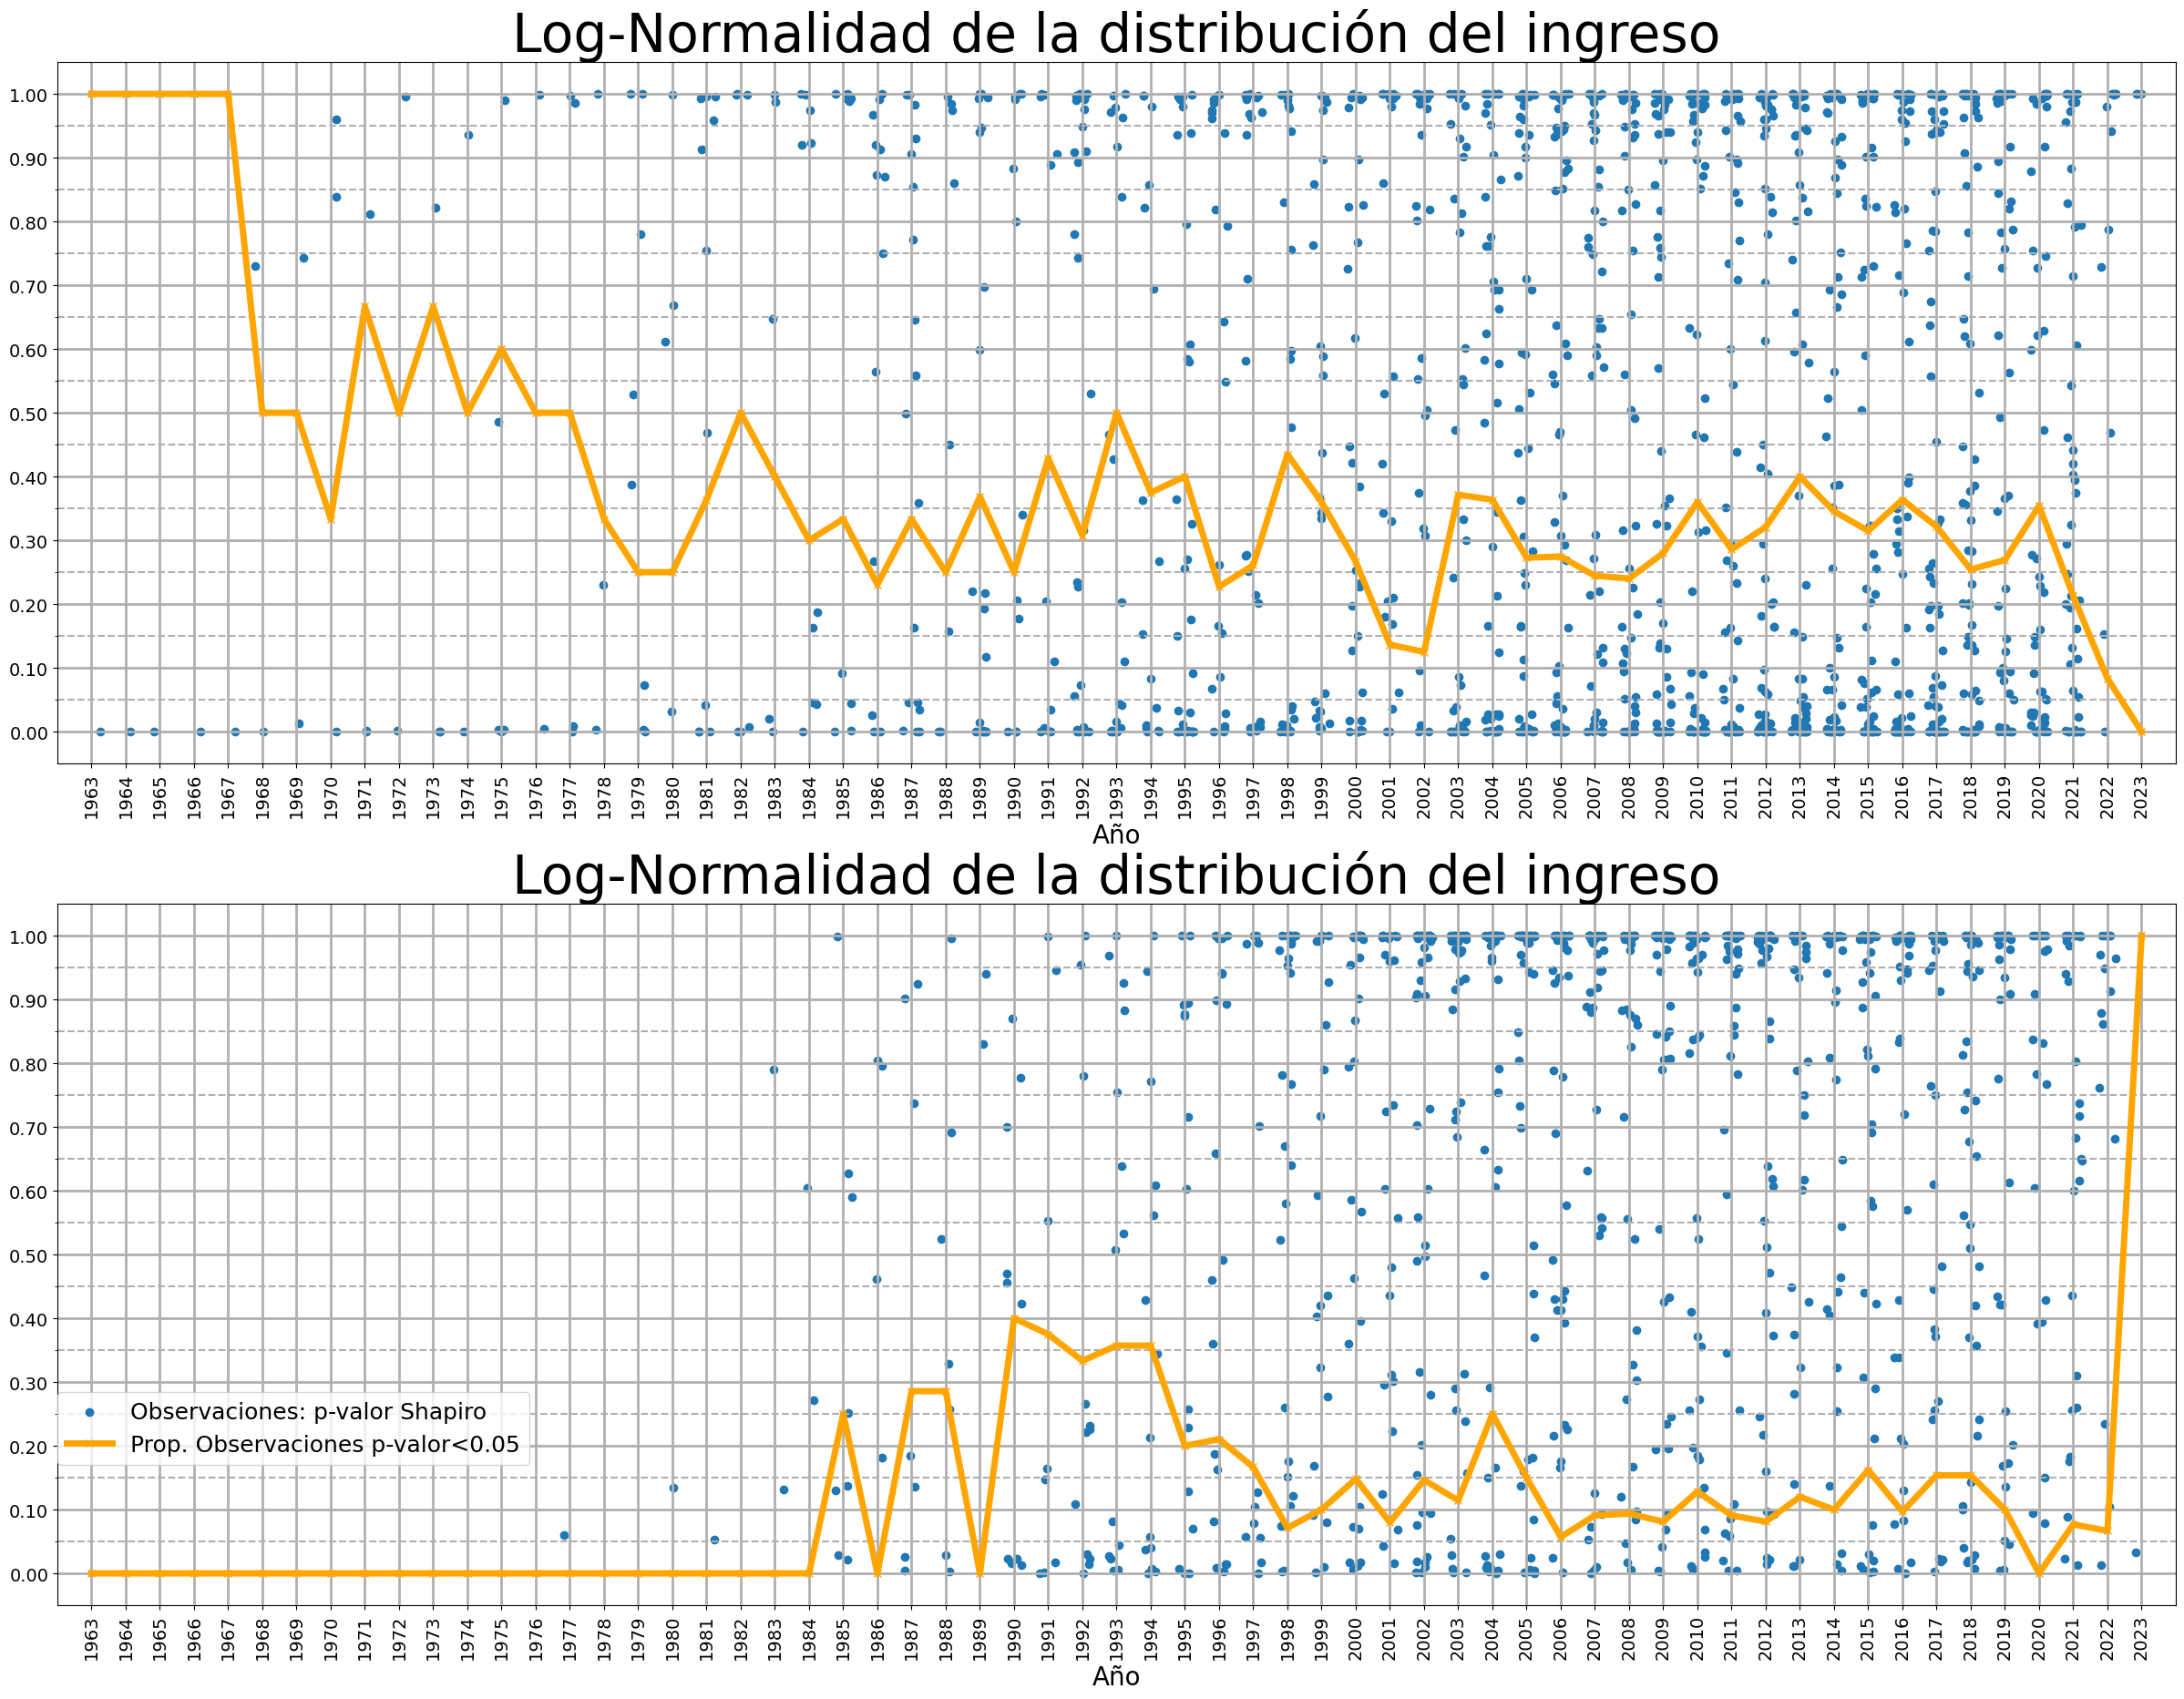

In [777]:
fig, axs = plt.subplots(2,1,figsize=(30,22))

Graficar(axs[0], GenSeries(datos_in))
Graficar(axs[1], GenSeries(datos_co))